# Ordinal Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from py_utils import math

In [14]:
# Generate random data to model
np.random.seed(1)

# Standard test
# n, n_class, n_var = 100000, 7, 5

# Regularization test
n, n_class, n_var = 1000, 5, 500

X = np.random.randn(n, n_var)

b_act = np.random.randn(n_var)
#b_out = np.sort(np.random.randn(n_class-1))
b_out = np.linspace(-2, 2, n_class-1)

y_logit = np.dot(X, b_act)[:, np.newaxis]
p = y_logit + np.tile(b_out, (n, 1))
p = math.sigmoid(p)
p = np.hstack((np.zeros((n, 1)), p, np.ones((n, 1))))
p = np.diff(p, axis=1)

y_vals = np.arange(1, n_class + 1)
assert len(y_vals) == p.shape[1]

y = np.array([np.random.choice(y_vals, size=1, p=p[i])[0] for i in range(n)])

X.shape, y.shape

((1000, 500), (1000,))

In [15]:
b_out

array([-2.        , -0.66666667,  0.66666667,  2.        ])

In [16]:
pd.Series(y).value_counts()

1    467
5    441
2     33
3     32
4     27
dtype: int64

In [53]:
from ml.scipy import optimize, models
param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()

# constraints.add_gtez('X0')
# constraints.add_gte('X1', 'X2')
# constraints.add_gte('X2', 'X3')
# constraints.add_gtev('X4', 2.0)

constraints.add_l2_regularization(param_names, 5.)

model = (
    models.ScipyOrdinalRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_outcome_intercepts(n_class)
    .add_constraints(constraints)
    .build()
)


In [54]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, monitor_gradient=True)
est.fit(X, y)

CPU times: user 48.1 s, sys: 540 ms, total: 48.6 s
Wall time: 12.2 s


In [55]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 37
    Number of function evaluations: 38
    Objective Function Value: 0.34162241259363463
    


In [56]:
est.get_gradient_error_history()

array([  1.38641217e-07,   1.77040340e-07,   5.53487795e-08,
         5.50916647e-08,   9.82103601e-08,   5.30693550e-08,
         7.44981104e-08,   5.83413931e-08,   5.49348604e-08,
         4.79452773e-08,   6.15098231e-08,   4.76964235e-08,
         5.16028500e-08,   4.98299966e-08,   4.55972128e-08,
         5.41110406e-08,   8.12422967e-08,   4.77580971e-08,
         8.81464213e-08,   5.68494358e-08,   5.04957121e-08,
         1.04795145e-07,   1.14245509e-07,   7.28589945e-08,
         5.18255941e-08,   6.74134680e-08,   4.83239396e-08,
         9.61059773e-08,   8.92322375e-08,   5.26000626e-08,
         6.39373594e-08,   7.70526939e-08,   5.60137361e-08,
         8.93245366e-08,   1.52431499e-07,   5.00644432e-08,
         5.40157913e-08])

In [57]:
est.fit_

     fun: 0.34162241259363463
     jac: array([ -5.40007061e-03,   7.77291976e-03,   1.38761756e-03,
        -3.56647570e-04,  -3.29281444e-03,   1.65988685e-03,
        -3.17035059e-03,  -5.76987268e-03,  -7.89889449e-05,
        -4.83283678e-04,  -4.25418874e-03,   1.48030813e-03,
        -2.88482005e-03,   5.45356207e-03,  -3.23198560e-03,
        -2.29059353e-03,  -1.12257312e-03,   1.78528829e-03,
        -3.03289496e-03,   1.82653571e-03,  -2.26834294e-03,
         2.40210900e-03,  -2.62808264e-03,   1.18901965e-03,
        -4.42860646e-03,   3.69567654e-04,  -2.50163484e-03,
         2.59948865e-04,  -1.39214763e-05,   5.87631099e-03,
         4.11483233e-03,   2.56571803e-03,   5.19426165e-03,
         1.25636085e-03,  -2.69321064e-03,   4.13842092e-03,
         7.93447558e-03,   4.09724278e-03,   6.81094957e-03,
        -5.08080102e-03,   3.98499926e-03,   1.20813301e-03,
        -1.41031389e-03,   4.84653491e-03,  -1.42093789e-03,
        -1.76659216e-03,   1.10894336e-03,  -

In [58]:
d_inf = est.inference()
d_inf

{'fit': OrderedDict(), 'linear': OrderedDict([('X0', 0.22400514209092673), ('X1', -0.32138090996040036), ('X2', -0.058501435112969867), ('X3', 0.015127542772515597), ('X4', 0.13560297520942333), ('X5', -0.069158708372352037), ('X6', 0.13179781684747266), ('X7', 0.23916564805909968), ('X8', 0.0039332647014255441), ('X9', 0.020296866763558706), ('X10', 0.1759991989332636), ('X11', -0.060356833438442385), ('X12', 0.11954717429590578), ('X13', -0.22667572366424454), ('X14', 0.13361251535053648), ('X15', 0.095908547310104536), ('X16', 0.047621388036509629), ('X17', -0.074948979517034997), ('X18', 0.12600949079329946), ('X19', -0.074264570237366656), ('X20', 0.093825534137877573), ('X21', -0.099249278242565034), ('X22', 0.1094645527405731), ('X23', -0.047394827137716908), ('X24', 0.18160586972061915), ('X25', -0.014656258902506518), ('X26', 0.10304710642254247), ('X27', -0.0097872377477803262), ('X28', 0.0010806500886731784), ('X29', -0.24323569159685832), ('X30', -0.17023339467566009), ('X3

In [59]:
b_act

array([  6.80462499e-01,  -1.90674304e+00,  -5.29078849e-01,
        -4.59898622e-01,   9.08161041e-01,  -7.59304328e-01,
         2.83780074e-01,   1.20050660e+00,  -4.47916763e-01,
        -1.28388474e-01,   9.55572446e-01,   3.11049999e-01,
         9.81574886e-01,  -1.10351346e+00,   4.95354336e-01,
         7.04852717e-01,   1.01875742e+00,  -3.93210127e-01,
         4.15124200e-01,  -7.51454194e-01,   7.25998731e-01,
        -1.23361250e+00,   5.61230467e-01,  -1.03670561e-02,
         1.47274753e+00,   3.44752532e-01,   3.86391508e-01,
        -7.49995659e-01,   7.81997280e-02,  -8.44016861e-01,
        -1.10376140e+00,  -5.46953958e-01,  -1.10394634e+00,
         1.75067999e-03,   2.22333440e-01,  -1.05463744e+00,
        -1.58264860e+00,  -1.02992071e+00,  -1.22331207e+00,
         1.26592749e+00,  -1.90324861e+00,   4.78113398e-02,
         1.53374686e-01,  -2.65535718e-01,   5.39066493e-01,
         4.84195004e-01,  -2.14988926e-01,   7.26778051e-01,
        -7.43698045e-01,

In [60]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

In [61]:
d_inf['linear'].head()

X0    0.224005
X1   -0.321381
X2   -0.058501
X3    0.015128
X4    0.135603
dtype: float64

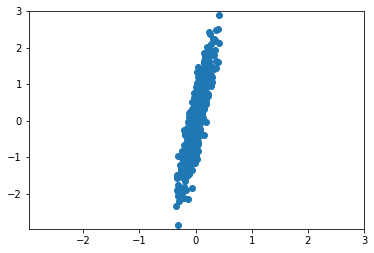

In [62]:
compare(pd.Series(d_inf['linear']), b_act)

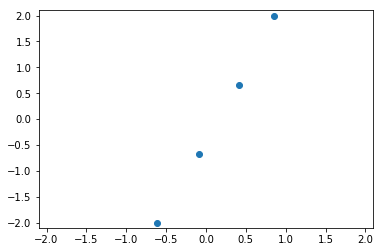

In [63]:
compare(pd.Series(d_inf['intercepts']), b_out)

In [64]:
d_proba = est.predict(X, key='probabilities')
d_proba[:5]

array([[ 0.05284383,  0.03318892,  0.04937286,  0.05940152,  0.80519288],
       [ 0.88058424,  0.04501882,  0.02831302,  0.01576   ,  0.03032391],
       [ 0.92299174,  0.02988702,  0.01825649,  0.00998784,  0.0188769 ],
       [ 0.94821356,  0.02043093,  0.01227061,  0.00664714,  0.01243776],
       [ 0.73582315,  0.0887187 ,  0.06206175,  0.03693469,  0.07646171]])

In [65]:
pd.Series(np.argmax(d_proba, axis=1) + 1).value_counts()

1    513
5    487
dtype: int64

In [66]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5
predicted,,,,,
1,467,28,16,2,nan
5,nan,5,16,25,441


In [34]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
pd.DataFrame({
    'predicted': GradientBoostingClassifier().fit(X, y).predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5
predicted,,,,,
1,467,nan,nan,nan,nan
2,nan,33,nan,nan,nan
3,nan,nan,32,nan,nan
4,nan,nan,nan,27,nan
5,nan,nan,nan,nan,441
